# Preprocesamiento

In [78]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt


# Mostrar todas las filas y columnas en outputs
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

df = pd.read_excel("datos_tarea25.xlsx")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Analísis y depuración de los datos. 
### Missing data
Con los valores perdidos tenemos 3 formas de solucionar este problema:
* Podemos borrar todas las observaciones que tengan valores perdidos
* Podemos imputar valores en estas observaciones
* Tener en cuenta cuales son los valores perdidos, crear una nueva vairable categorica e imputar valores en estas observaciones.
Obviamente usaremos la última opción en la mayoría de los casos ya que es la forma de no perder información. Y ya no solo eso, sino que también mantenmos la información que nos da el dataset, puesto que estos valores perdidos pueden ser importantes a la hora de predecir nuestra variable dependiente.

### afsfdasfe
Lo primero que haremos será formalizar nuestro DataFrame para poder ser utilizado, para ello realizaremos los siguientes peuqños cambios:
* Detectaremos todas las variables dicotomicas y las convertiremos en 0 y 1
* Quitaremos el string "km" de toda la columna de "Mileage"
* En la columna "Engine volume", algunos coches tienen "Turbo" en su motor, para poder utilizar bien esta variable y no perder los datos sobre aquellos coches que tienen turbo, he eleiminado el string "Turbo" y he creado una variable dicotomica para todas aquellas observaciones que tienen "Turbo".
* En la variable "Levy" he eliminado los valores de "-" y he imputado **joafodjjfa**


In [79]:
df["Levy"] = df["Levy"].replace("-", np.nan)
df["Levy -"] = df["Levy"].isna()
df["Levy"] = pd.to_numeric(df["Levy"], errors="coerce")
mediana_levy = df["Levy"].median()
df["Levy"] = df["Levy"].fillna(mediana_levy)

df["Levy"]

0         891.0
1         761.0
2         394.0
3        1053.0
4        1055.0
5         891.0
6        1079.0
7         810.0
8        1850.0
9        1249.0
10        836.0
11       2455.0
12        836.0
13       1750.0
14        382.0
15       1017.0
16        836.0
17       1017.0
18        836.0
19        779.0
20        645.0
21       1053.0
22       2455.0
23       1324.0
24        830.0
25        781.0
26        531.0
27        639.0
28       1604.0
29        891.0
30        687.0
31      11714.0
32        836.0
33        779.0
34       1537.0
35        781.0
36       1811.0
37       1646.0
38        836.0
39       1017.0
40        609.0
41        394.0
42        690.0
43       1079.0
44        308.0
45        531.0
46        836.0
47        751.0
48        765.0
49        645.0
50        639.0
51        836.0
52        831.0
53       1249.0
54        836.0
55       1017.0
56        836.0
57        831.0
58       1053.0
59        779.0
60        879.0
61       1342.0
62      

In [80]:
from Pyurification import Pyurification

pyrf = Pyurification(df)

pyrf.change_to_num(["Prod. year", "Engine volume", "Airbags"])
pyrf.remove_string_from_num("Mileage")
pyrf.create_and_remove_string_from_num("Engine volume")
pyrf.onehotencoder(["Manufacturer", "Category", "Fuel type", "Drive wheels"], drop=None)

c:\Users\Usuario\Desktop\Ejercicios de uni\Machine learning tarea 1\Pyurification.py:116: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return series.replace({val_unicos[0]:0, val_unicos[1]:1})


In [81]:
X = pyrf.df


y = X["Color"]
X.drop(columns="Color", inplace=True)

## División de los datos 

In [82]:
from sklearn.model_selection import train_test_split

test_size = 0.2
random_state = 777

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
print(f"La frecuencia de cada clase en train es: \n{y_train.value_counts(normalize=True)}")
print(f"La frecuencia de cada clase en test es: \n{y_test.value_counts(normalize=True)}")

La frecuencia de cada clase en train es: 
Color
0    0.531394
1    0.468606
Name: proportion, dtype: float64
La frecuencia de cada clase en test es: 
Color
0    0.5553
1    0.4447
Name: proportion, dtype: float64


In [84]:
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.25, random_state=777):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)

        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, X_test, y_test)
               
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_append(scores[best])
       
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)

        return score

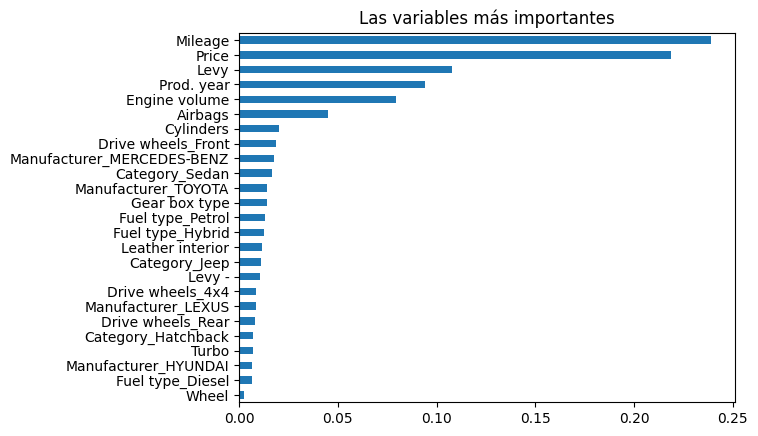

In [86]:
from sklearn.ensemble import RandomForestClassifier

model_feature = RandomForestClassifier(random_state=42)
model_feature.fit(X, y)

importancia = pd.Series(model_feature.feature_importances_, index=X.columns)
importancia = importancia.sort_values(ascending=False)


importancia.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Las variables más importantes")
plt.show()

# Árbol de clasificación
## Busqueda paramétrica del mejor árbol

In [ ]:
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score

from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

# Tuneo
params={
    "max_depth":[2, 3, 5, 10, 20],
    "min_samples_split":[5, 10, 20, 50, 100],
    "criterion": ["gini", "entropy"]
}
scoring_metrics = ["accuracy", "precision_macro", "recall_macro", "f1_macro"]


#Cross Validation
decision_tree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=decision_tree,
                           param_grid=params,
                           cv=4,
                           scoring=scoring_metrics,
                           refit="accuracy")
grid_search.fit(X_train, y_train)


# Obtenemos los resultados del grid search.
results = pd.DataFrame(grid_search.cv_results_)

results.sort_values(by="mean_test_accuracy", ascending=False, inplace=True)
results[["params", "mean_test_accuracy", "mean_test_precision_macro", "mean_test_recall_macro", "mean_test_f1_macro"]].head(5)


,params,mean_test_accuracy,mean_test_precision_macro,mean_test_recall_macro,mean_test_f1_macro
45,"{'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 5}",0.752304,0.752310,0.750872,0.750920
20,"{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 5}",0.747696,0.747181,0.745595,0.746013
21,"{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 10}",0.745968,0.745775,0.743646,0.744062
15,"{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}",0.742800,0.742089,0.740842,0.741180
46,"{'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 10}",0.741935,0.742041,0.740528,0.740465


In [ ]:
# Usaremos unos cuantos modelo
res_1 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[0]
res_2 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[1]
res_3 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[2]
res_4 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[3]
res_5 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[4]


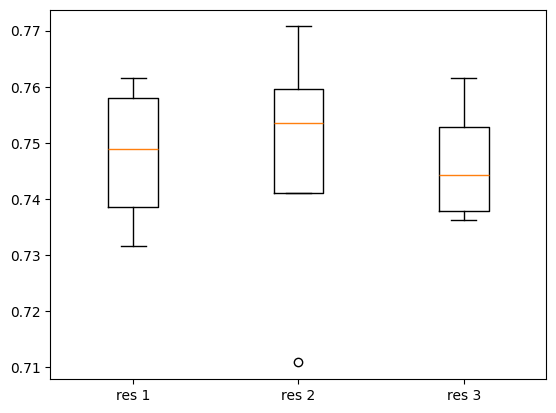

In [ ]:
# Creamos una boxplot para los valores de accuracy
# Es importante recordar que los boxplots con gran amplitud son malos porque no tiene robustez
plt.boxplot([res_1.values, res_2.values, res_3.values, res_4.values, res_5.values], 
            labels=["res 1", "res 2", "res 3", "res 4", "res 5"])
plt.show()

Finalmente nos quedaremos con el modelo del resultado 2

In [ ]:
mejor_modelo = results.iloc[1]["params"]

In [ ]:
# Empezamos a predecir
mejor_arbol = DecisionTreeClassifier(**mejor_modelo)
mejor_arbol.fit(X_train, y_train)
mejor_arbol.get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier(max_depth=20, min_samples_split=5)>

In [ ]:
# Predicciones en train y test
y_train_predict = mejor_arbol.predict(X_train)
y_test_predict = mejor_arbol.predict(X_test)

# Medidas de bondad de ajuste en train
conf_matrix = confusion_matrix(y_train, y_train_predict)
print(conf_matrix)
print("Medidas de desempeño")
print(classification_report(y_train, y_train_predict))


[[1809   36]
 [  93 1534]]
Medidas de desempeño
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1845
           1       0.98      0.94      0.96      1627

    accuracy                           0.96      3472
   macro avg       0.96      0.96      0.96      3472
weighted avg       0.96      0.96      0.96      3472



Area bajo la curva ROC 1.00


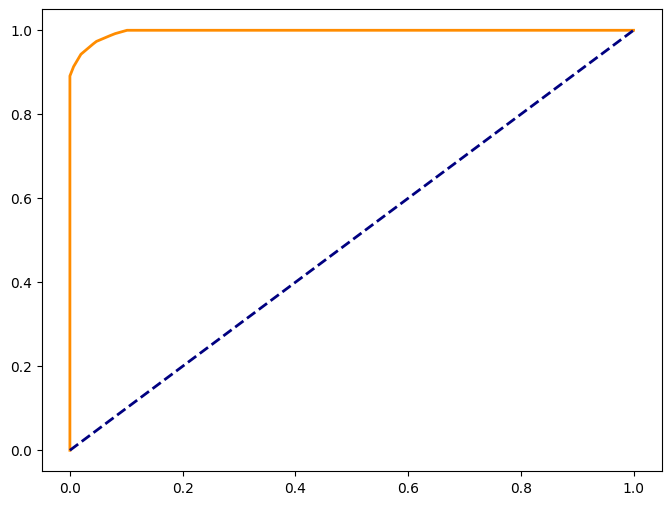

In [ ]:
# Curvas ROC
y_train_auc = pd.get_dummies(y_train, drop_first=True)

# Calcular el area bajo la curva ROC
y_prob_train = mejor_arbol.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train_auc, y_prob_train)
roc_auc = (auc(fpr, tpr))
print(f"Area bajo la curva ROC {roc_auc:.2f}")

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0,1], color="navy", lw=2, linestyle="--")
plt.show()

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF_model = RandomForestClassifier()
# Tuneo de los hiperparametros
params = {
    'n_estimators' : [50,100,150],
    'max_depth': [2, 3, 5, 10, 20],
    'bootstrap': [True, False],
    'min_samples_leaf' : [3,10,30],
    'min_samples_split': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
# cv = crossvalidation
grid_search_RF = GridSearchCV(estimator=RF_model, 
                           param_grid=params, 
                           cv=4, 
                           scoring = scoring_metrics, 
                           refit='accuracy')
grid_search_RF.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [3, 10, 30],
                         'min_samples_split': [5, 10, 20, 50, 100],
                         'n_estimators': [50, 100, 150]},
             refit='accuracy',
             scoring=['accuracy', 'precision_macro', 'recall_macro',
                      'f1_macro'])

In [ ]:
# Obtener resultados del grid search
results = pd.DataFrame(grid_search_RF.cv_results_)

results.sort_values(by="mean_test_accuracy", ascending=False, inplace=True)
results[["params", "mean_test_accuracy", "mean_test_precision_macro", "mean_test_recall_macro", "mean_test_f1_macro"]].head(5)

,params,mean_test_accuracy,mean_test_precision_macro,mean_test_recall_macro,mean_test_f1_macro
855,"{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}",0.775922,0.775407,0.774477,0.774711
860,"{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 150}",0.775634,0.775060,0.774169,0.774403
635,"{'bootstrap': False, 'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 150}",0.774482,0.774059,0.772653,0.773064
631,"{'bootstrap': False, 'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}",0.773618,0.773110,0.772161,0.772374
857,"{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 150}",0.772753,0.772244,0.771061,0.771399


In [ ]:
res_1 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[0]
res_2 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[1]
res_3 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[2]
res_4 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[3]
res_5 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[4]

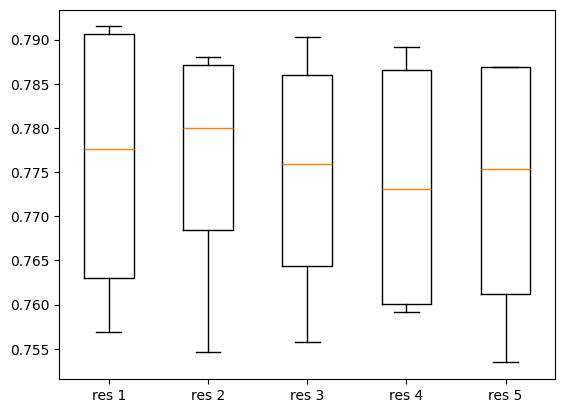

In [ ]:
# Creamos una boxplot para los valores de accuracy
# Es importante recordar que los boxplots con gran amplitud son malos porque no tiene robustez
plt.boxplot([res_1.values, res_2.values, res_3.values, res_4.values, res_5.values], 
            labels=["res 1", "res 2", "res 3", "res 4", "res 5"])
plt.show()

In [ ]:
mejor_modelo_RF = results.iloc[1]["params"]

In [ ]:
# Empezamos a predecir
mejor_RF = RandomForestClassifier(**mejor_modelo_RF)
mejor_RF.fit(X_train, y_train)
mejor_RF.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=20,
                       min_samples_leaf=3, min_samples_split=10,
                       n_estimators=150)>

In [ ]:
# Predicciones en train y test
y_train_predict = mejor_RF.predict(X_train)
y_test_predict = mejor_RF.predict(X_test)

# Medidas de bondad de ajuste en train
conf_matrix = confusion_matrix(y_train, y_train_predict)
print(conf_matrix)
print("Medidas de desempeño")
print(classification_report(y_train, y_train_predict))

[[1705  140]
 [  91 1536]]
Medidas de desempeño
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      1845
           1       0.92      0.94      0.93      1627

    accuracy                           0.93      3472
   macro avg       0.93      0.93      0.93      3472
weighted avg       0.93      0.93      0.93      3472



Area bajo la curva ROC 0.99


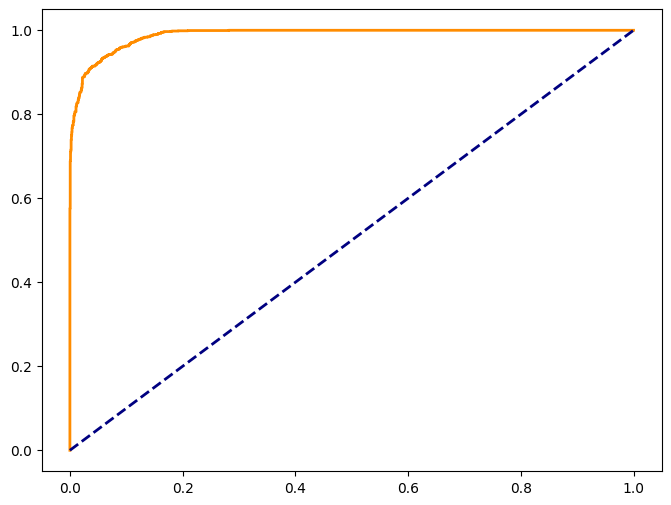

In [ ]:
# Curvas ROC
y_train_auc = pd.get_dummies(y_train, drop_first=True)

# Calcular el area bajo la curva ROC
y_prob_train = mejor_RF.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train_auc, y_prob_train)
roc_auc = (auc(fpr, tpr))
print(f"Area bajo la curva ROC {roc_auc:.2f}")

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0,1], color="navy", lw=2, linestyle="--")
plt.show()

# XGBoost

In [ ]:
X["Levy"].dtype

dtype('O')

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

params = {
    'n_estimators': [100,200,300],
    'eta' : [0.1,0.4,0.7],
    'gamma' : [0.1,0.5,1],
    'max_depth': [5, 10]
}

scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
#recordar que arbol2 es el árbol cuyas VI son todas las variables.
# cv = crossvalidation
grid_search_XGB = GridSearchCV(estimator=xgb, 
                           param_grid=params, 
                           cv=4, scoring = scoring_metrics, refit='accuracy')
grid_search_XGB.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'eta': [0.1, 0.4, 0.7], 'gamma': [0.1, 0.5, 1],
                         'max_depth': [5, 10],
                         'n_estimators': [100, 200, 300]},
             refit='accuracy',
             scoring=['accuracy', 'precision_macro', 'recall_macro',
                      'f1_macro'])

In [ ]:
# Obtener resultados del grid search
results = pd.DataFrame(grid_search_XGB.cv_results_)

results.sort_values(by="mean_test_accuracy", ascending=False, inplace=True)
results[["params", "mean_test_accuracy", "mean_test_precision_macro", "mean_test_recall_macro", "mean_test_f1_macro"]].head(5)

,params,mean_test_accuracy,mean_test_precision_macro,mean_test_recall_macro,mean_test_f1_macro
47,"{'eta': 0.7, 'gamma': 0.5, 'max_depth': 10, 'n_estimators': 300}",0.769009,0.768302,0.767869,0.767950
46,"{'eta': 0.7, 'gamma': 0.5, 'max_depth': 10, 'n_estimators': 200}",0.769009,0.768302,0.767869,0.767950
45,"{'eta': 0.7, 'gamma': 0.5, 'max_depth': 10, 'n_estimators': 100}",0.769009,0.768302,0.767869,0.767950
3,"{'eta': 0.1, 'gamma': 0.1, 'max_depth': 10, 'n_estimators': 100}",0.766417,0.765607,0.765428,0.765434
11,"{'eta': 0.1, 'gamma': 0.5, 'max_depth': 10, 'n_estimators': 300}",0.765553,0.764916,0.764617,0.764556


In [ ]:
res_1 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[0]
res_2 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[1]
res_3 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[2]
res_4 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[3]
res_5 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[4]

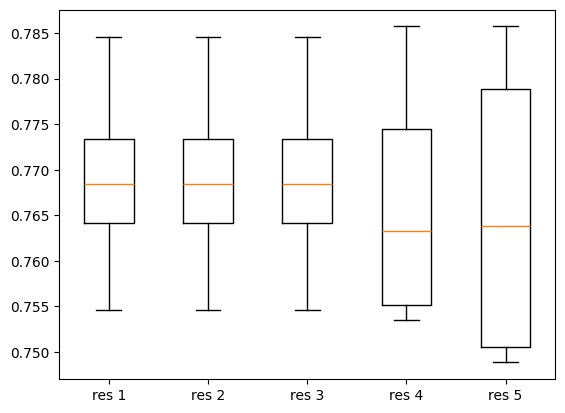

In [ ]:
# Creamos una boxplot para los valores de accuracy
# Es importante recordar que los boxplots con gran amplitud son malos porque no tiene robustez
plt.boxplot([res_1.values, res_2.values, res_3.values, res_4.values, res_5.values], 
            labels=["res 1", "res 2", "res 3", "res 4", "res 5"])
plt.show()

In [ ]:
mejor_XGB = results.iloc[1]["params"]

In [ ]:
# Empezamos a predecir
mejor_XGB = XGBClassifier(**mejor_XGB)
mejor_XGB.fit(X_train, y_train)
mejor_XGB.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.7, eval_metric=None,
              feature_types=None, gamma=0.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)>

In [ ]:
# Predicciones en train y test
y_train_predict = mejor_XGB.predict(X_train)
y_test_predict = mejor_XGB.predict(X_test)

# Medidas de bondad de ajuste en train
conf_matrix = confusion_matrix(y_train, y_train_predict)
print(conf_matrix)
print("Medidas de desempeño")
print(classification_report(y_train, y_train_predict))

[[1741  104]
 [  79 1548]]
Medidas de desempeño
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1845
           1       0.94      0.95      0.94      1627

    accuracy                           0.95      3472
   macro avg       0.95      0.95      0.95      3472
weighted avg       0.95      0.95      0.95      3472



Area bajo la curva ROC 0.99


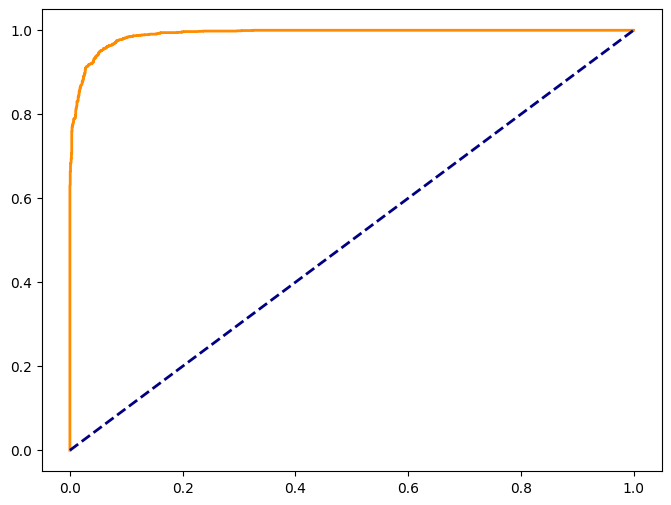

In [ ]:
# Curvas ROC
y_train_auc = pd.get_dummies(y_train, drop_first=True)

# Calcular el area bajo la curva ROC
y_prob_train = mejor_XGB.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train_auc, y_prob_train)
roc_auc = (auc(fpr, tpr))
print(f"Area bajo la curva ROC {roc_auc:.2f}")

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0,1], color="navy", lw=2, linestyle="--")
plt.show()